# Risk Identification Model

# Load The Dataset

This code imports necessary libraries for data processing, modeling, and visualization. It uses *Pandas* and *NumPy* for data manipulation, while *scikit-learn* provides tools for building and evaluating an *Isolation Forest* model for anomaly detection. Additionally, *Matplotlib* and *Seaborn* are used for creating visualizations to interpret results. Five datasets containing account information, fraud claims, account features, statements, and transactions are loaded for analysis. These datasets will be used to identify anomalies and detect potentially fraudulent accounts.

In [6]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
account_data = pd.read_csv('data/account_dim_20250325.csv')
fraud_data = pd.read_csv('data/fraud_claim_case_20250325.csv')
account_features = pd.read_csv('data/rams_batch_cur_20250325.csv')
statement_data = pd.read_csv('data/statement_fact_20250325.csv')
transaction_data = pd.read_csv('data/transaction_fact_20250325.csv')

This section contains functions to clean and preprocess the datasets for further analysis. 

The *clean_rams()* function processes the account features dataset by converting dates, removing unnecessary columns, handling missing values, and replacing invalid values with meaningful ones. Similarly, the *clean_accounts()* function handles the account data, removing duplicates, filling missing values, and converting payment history into a usable format by creating separate month columns. High-spending customers are also identified based on specific flags.

The *clean_transaction_data()* function removes irrelevant columns from the transaction data, reducing redundancy and ensuring only relevant information is retained. For fraud data, the *clean_fraud_data()* function creates flags to indicate if fraud occurred in the last 12 months and if the fraud amount exceeded $1000. Finally, the *encode_month_in_accounts()* function encodes payment history values into numeric representations for further analysis. After applying these functions, the cleaned datasets are ready for model building and anomaly detection.

In [7]:
# Function to clean the RAMS dataset
def clean_rams(df):
    # Convert date column to datetime format
    df['cu_processing_date'] = pd.to_datetime(df['cu_processing_date'])

    # Keep only the latest processing date for each account
    latest_df = df.sort_values(by=['cu_processing_date'], ascending=False).drop_duplicates(subset=['cu_account_nbr'], keep='first')

    # drop the ca_cash_bal_pct_crd_line column
    df = df.drop(columns=['ca_cash_bal_pct_crd_line'])
    # irrelevant column as the values are all 0

    #drop the cu_nbr_days_dlq column
    df = df.drop(columns=['cu_nbr_days_dlq'])
    #redundant as theres a simialr column with months which is more useful

    #drop the ca_cash_bal_pct_cash_line column
    df = df.drop(columns=['ca_cash_bal_pct_cash_line'])

    #For all values in column cu_crd_bureau_scr , replace the value 0 with median of the column cu_crd_bureau_scr
    df['cu_crd_bureau_scr'] = df['cu_crd_bureau_scr'].replace(0, df['cu_crd_bureau_scr'].median())

    #drop the column cu_next_crd_line_rev_date
    df = df.drop(columns=['cu_next_crd_line_rev_date'])
    #irrelevant column as majority values are 0

    #dropping columns
    useless_col = [
        'cu_cur_balance',
        'ca_mob',
        'cu_rnd_nbr',
        'rb_crd_gr_new_crd_gr',
        'cu_processing_date',
        'mo_tot_sales_array_1',
        'mo_tot_sales_array_2',
        'mo_tot_sales_array_3',
        'mo_tot_sales_array_4',
        'mo_tot_sales_array_5',
        'mo_tot_sales_array_6'
    ]

    #Droping the above generated columns
    df = df.drop(columns=useless_col)

    # for the values 999999999999999 in cu_cash_line_am replace them with 20% of corresponding valur of cu_crd_bureau_scr column 
    df['cu_cash_line_am'] = df.apply(
        lambda row: row['cu_crd_bureau_scr'] * 0.2 if row['cu_cash_line_am'] == 999999999999999 else row['cu_cash_line_am'],
        axis=1
    )
    # round it off to 2 decimal places
    df['cu_cash_line_am'] = df['cu_cash_line_am'].round(2)

    #drop duplicate rows with duplicate values in the column cu_account_nbr
    df = df.drop_duplicates(subset=['cu_account_nbr'])

    return df

# Function to clean the account dataset
def clean_accounts(df):
    account_df = df.copy()

    # replace all \\\"\\\" values with NaN
    account_df.replace(r'\\\"', np.nan, regex=True, inplace=True)

    # drop duplicate rows
    account_df.drop_duplicates(inplace=True)
    
    # drop useless columns
    useless_column  = ['date_in_collection', # All values are null
                       'special_finance_charge_ind', # All values are null
                       'card_activation_date', # Redundant since we have card_activation_flag
                       'ebill_ind', # Not usefull for computing credit_line increase
                       'overlimit_type_flag', # All values are 0
                       'external_status_reason_code' # Redundant with ext_status_reason_cd_desc
                       ]
    account_df.drop(columns=useless_column, inplace=True, errors='ignore')

    # convert date columns to datetime
    date_columns = ['open_date']
    for col in date_columns:
        account_df[col] = pd.to_datetime(account_df[col], errors='coerce')

    # update the card_activation_flag to 0 or 1. 
    account_df['card_activation_flag'] = account_df['card_activation_flag'].replace({'0': 1, '7': 0, '8': 0, np.nan: 0})

    # Create empty columns for each month
    for i in range(12):
        account_df[f"Month_{i+1}"] = account_df['payment_hist_1_12_mths'].apply(lambda x: x[i] if pd.notna(x) and i < len(x) else np.nan)

    for i in range(12):
        account_df[f"Month_{i+13}"] = account_df['payment_hist_13_24_mths'].apply(lambda x: x[i] if pd.notna(x) and i < len(x) else np.nan)

    # Drop the original payment history columns
    account_df.drop(columns=['payment_hist_1_12_mths', 'payment_hist_13_24_mths'], inplace=True)

    # Update the employee_code column.
    account_df['high_spending_customer'] = account_df['employee_code'].replace({'H': 1, 'Y': 0, '': 0, np.nan: 0})
    account_df['employee_code'] = account_df['employee_code'].replace({'Y': 1, 'H': 0, '': 0, np.nan: 0})

    return account_df

# Function to clean the transaction dataset
def clean_transaction_data(df):

    df = df.copy()

    uselss_column=[
                'payment_type',
                'transaction_return_cnt',
                'transaction_sale_cnt',
                'product_amt',
                'product_qty',
                'invoice_nbr',
                'first_purchase_ind',
                'adj_orgn_tran_dt',
                'curr_markup_fee',
                'fcr_amount',
                'fcr_flag',
                'fcr_rate_of_exchange',
                'posting_date']
    
    #drop the useless columns
    df.drop(uselss_column,axis=1,inplace=True)

    return df

# Clean fraud data
def clean_fraud_data(df):
    # Convert date columns to datetime
    df['reported_date'] = pd.to_datetime(df['reported_date'], errors='coerce')

    # create a new column which is set to 1 if fraud happened in the last 12 months and 0 otherwise
    df['fraud_last_12_months'] = df['reported_date'].apply(lambda x: 1 if (pd.to_datetime('today') - x).days <= 365 else 0)
    # create a new column which is set to 1 if fraud amount is greater than 1000 and 0 otherwise
    df['fraud_amount_gt_1000'] = df['gross_fraud_amt'].apply(lambda x: 1 if x > 1000 else 0)

    # drop all column except the current_account_nbr, fraud_last_12_months and fraud_amount_gt_1000
    df = df[['current_account_nbr', 'fraud_last_12_months', 'fraud_amount_gt_1000']]

    return df

def encode_month_in_accounts(df):
    # Define encoding dictionary
    encoding_dict = {
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7,  # No Activity
        'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7,  # Debit-Only Activity
        'I': 0, 'J': 1, 'K': 2, 'L': 3, 'M': 4, 'N': 5, 'O': 6, 'P': 7,  # Credit-Only Activity
        '%': 0, '#': 0, '+': 0, '--': 0, 'z': 0, 'Q': 0, 'Z': 0  # Neutral risk indicators
    }
    month_columns = ['Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6','Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12','Month_13', 'Month_14', 'Month_15', 'Month_16', 'Month_17', 'Month_18','Month_19', 'Month_20', 'Month_21', 'Month_22', 'Month_23', 'Month_24']
    df[month_columns] = df[month_columns].astype(str)
    # Apply encoding only to month columns
    df[month_columns] = df[month_columns].applymap(lambda x: encoding_dict.get(x, 0))

    return df

account_data = clean_accounts(account_data)
account_data = encode_month_in_accounts(account_data)
account_features = clean_rams(account_features)
transaction_data = clean_transaction_data(transaction_data)
fraud_data = clean_fraud_data(fraud_data)

/var/folders/h7/qn2fn7996dn7y9sp2_ptj5h40000gn/T/ipykernel_14952/2618338422.py:81: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  account_df[col] = pd.to_datetime(account_df[col], errors='coerce')
/var/folders/h7/qn2fn7996dn7y9sp2_ptj5h40000gn/T/ipykernel_14952/2618338422.py:84: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  account_df['card_activation_flag'] = account_df['card_activation_flag'].replace({'0': 1, '7': 0, '8': 0, np.nan: 0})
/var/folders/h7/qn2fn7996dn7y9sp2_ptj5h40000gn/T/i

This code merges multiple datasets using *current_account_nbr* as the primary key to create a comprehensive dataset for analysis. The account data is merged with the statement data, fraud data, and account features using a *left join*, ensuring that all accounts from the primary dataset are retained even if matching records are not available in the other datasets.

The merged dataset consolidates account information, financial statements, fraud history, and account-level features into a single view. This enriched dataset will be useful for further analysis, model training, and anomaly detection. The shape of the merged data is printed to verify the number of rows and columns, providing a quick check on the success of the merge operation.

In [8]:

# Merge datasets on the primary key (current_account_nbr)
merged_data = account_data.merge(statement_data, on="current_account_nbr", how="left") \
                          .merge(fraud_data, on="current_account_nbr", how="left") \
                          .merge(account_features, left_on="current_account_nbr", right_on="cu_account_nbr", how="left")

# Inspect merged data
print("Merged Data Shape:", merged_data.shape)



Merged Data Shape: (658685, 60)


This code performs additional data preprocessing by filtering and refining the merged dataset. 

First, it removes accounts with a *card activation flag* of ⁠ 0 ⁠, ensuring that only active accounts are retained for analysis. This is important because inactive accounts are irrelevant for detecting anomalies or identifying risks.

Next, it creates a new feature called *Payment_Hist_Sum*, which is the sum of all monthly payment history columns. This provides a consolidated view of a customer’s payment behavior over the past two years, making it easier for the model to detect patterns.

Finally, since the individual monthly columns are no longer needed after summing their values, they are dropped using the ⁠ drop() ⁠ function. This reduces data dimensionality, improving model efficiency and interpretability. The resulting dataset is clean, focused, and ready for further modeling.

In [9]:
# filter out the rows with 0 as activation flag
merged_data = merged_data[merged_data['card_activation_flag'] == 1]

merged_data['Payment_Hist_Sum'] = merged_data.filter(like='Month_').sum(axis=1)
# Remove rows with all month columns
merged_data = merged_data.drop(columns=[f'Month_{i}' for i in range(1, 25)])


This code performs feature selection, trains an **Isolation Forest** model for anomaly detection, and visualizes the results.

First, relevant features are selected from the cleaned dataset, focusing on factors like payment history, credit scores, account utilization, and fraud-related attributes. The data is then split into **training** and **testing** sets using an 80-20 ratio to ensure effective model evaluation.

The **Isolation Forest** model is trained on the training set to identify anomalies, with hyperparameters like the number of estimators, contamination rate, and sampling size configured for optimal performance. After training, predictions are made on the test set, where anomalies are labeled as `1` and normal accounts as `0`.

Finally, the results are visualized using a **pie chart** to show the proportion of anomalous and non-anomalous accounts. This helps in understanding the prevalence of suspicious activities within the dataset, providing actionable insights for fraud detection and risk management.

Total Anomalous Accounts Detected: 5837


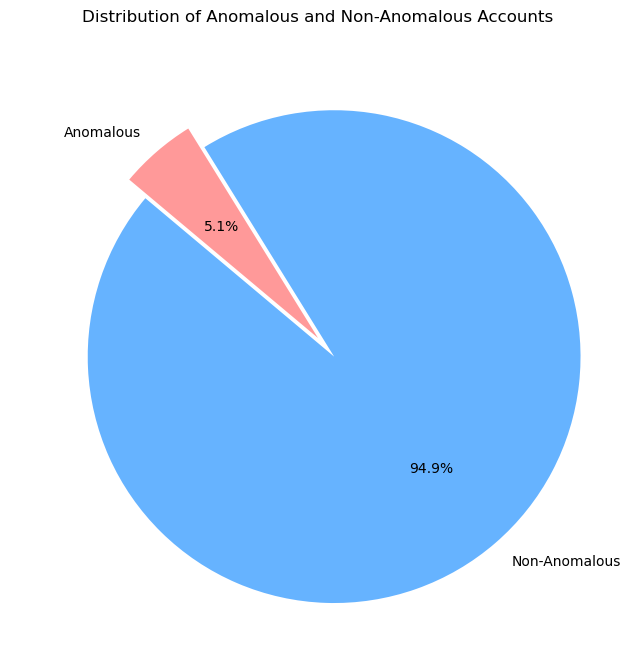

In [10]:
# Feature selection
features = [
    'Payment_Hist_Sum', 'cu_bhv_scr', 'ca_avg_utilz_lst_6_mnths', 'cu_crd_bureau_scr', 'cu_cur_nbr_due',
    'ca_max_dlq_lst_6_mnths', 'ca_mnths_since_active', 'ca_mnths_since_cl_chng',
    'ca_nsf_count_lst_12_months', 'fraud_amount_gt_1000',
    'return_check_cnt_2yr', 'return_check_cnt_total'
]

# Select features for training
X = merged_data[features]

# Split the data into training and testing sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Train Isolation Forest
iso_forest = IsolationForest(
    n_estimators=300, 
    max_samples=0.9, 
    contamination=0.05, 
    random_state=42, 
    bootstrap=True, 
    max_features=1.0  
)
iso_forest.fit(X_train)

# Make predictions on test data
y_pred = iso_forest.predict(X_test)

# Convert predictions to binary risk labels: 1 (Anomalous), 0 (Normal)
y_pred_labels = np.where(y_pred == -1, 1, 0)

# Merge 'current_account_nbr' with X_test
X_test_with_account_nbr = X_test.copy()
X_test_with_account_nbr['current_account_nbr'] = merged_data.loc[X_test.index, 'current_account_nbr']
X_test_with_account_nbr['Risk_Label'] = y_pred_labels

# Identify anomalous and non-anomalous accounts
anomalous_accounts = X_test_with_account_nbr[X_test_with_account_nbr['Risk_Label'] == 1].copy()
non_anomalous_accounts = X_test_with_account_nbr[X_test_with_account_nbr['Risk_Label'] == 0].copy()

# Print total anomalous accounts detected
print("Total Anomalous Accounts Detected:", len(anomalous_accounts))

# Plot a pie chart for anomalous and non-anomalous accounts
plt.figure(figsize=(8, 8))
labels = ['Non-Anomalous', 'Anomalous']
sizes = X_test_with_account_nbr['Risk_Label'].value_counts()
colors = ['#66b3ff', '#ff9999']
explode = (0.1, 0)  # explode the first slice (Non-Anomalous)

plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Anomalous and Non-Anomalous Accounts')
plt.show()
